Developed by: Marcus Genzel, Thomas Reimann

TU Dresden, Institute of Groundwater Management, Dresden, Germany 

Contact: marcus.genzel@tu-dresden.de / thomas.reimann@tu-dresden.de 

Last Updated: 06.03.2023
___

In [19]:
# Load required modules/packages
import os

import flopy
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Initialize the model
# Create the model object
modelname = 'mf_theis' # name of the model
model_ws = os.path.join(os.getcwd(), 'mf_theis') # model workspace
model = flopy.modflow.Modflow(
    modelname, 
    exe_name='mf2005', 
    version='mf2005', 
    model_ws= model_ws,
    verbose= True
    )

In [21]:
# Compute the number of time steps under consideration of a time step multiplier
start_time = 60  # Starting time (seconds)
end_time = 86400  # End time (seconds)
time_step = 60  # Initial time step (seconds)
max_steps = 0
TSMULT = 1.1

while start_time < end_time:
    start_time += time_step
    time_step *= TSMULT
    max_steps += 1

print("Maximum number of steps:", max_steps)

Maximum number of steps: 53


In [22]:
# DIS - Discretization (Spatial and Temporal Discretization)

lenuni = 'Meters' # Length unit 
itmuni = 'Seconds' # Time unit
nlay = 1  # Number of layers
nrow = 21  # Number of rows
ncol = 21  # Number of columns
delr = 200.0  # Grid spacing along rows (m)
delc = 200.0  # Grid spacing along columns (m)
nper = 1  # Number of stress periods
perlen = 86400  # Length of each stress period (s)
steady = [0]  # Steady-state flag for each stress period (0: transient, 1: steady-state)
#nstp = 86400 / 60  # Number of time steps for each stress period
nstp = max_steps
#tsmult = 1.0  # Time step multiplier
tsmult = 1.1
top = 15  # Elevation of the top of the model (m)
botm = 0  # Elevation of the bottom of the model (m)

# Define the discretization object
dis = flopy.modflow.ModflowDis(
    model, 
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top,
    botm=botm,
    nper=nper,
    perlen=perlen,
    steady=steady,
    itmuni=itmuni,
    lenuni=lenuni,
    tsmult=tsmult,
    nstp=nstp
    )



adding Package:  DIS


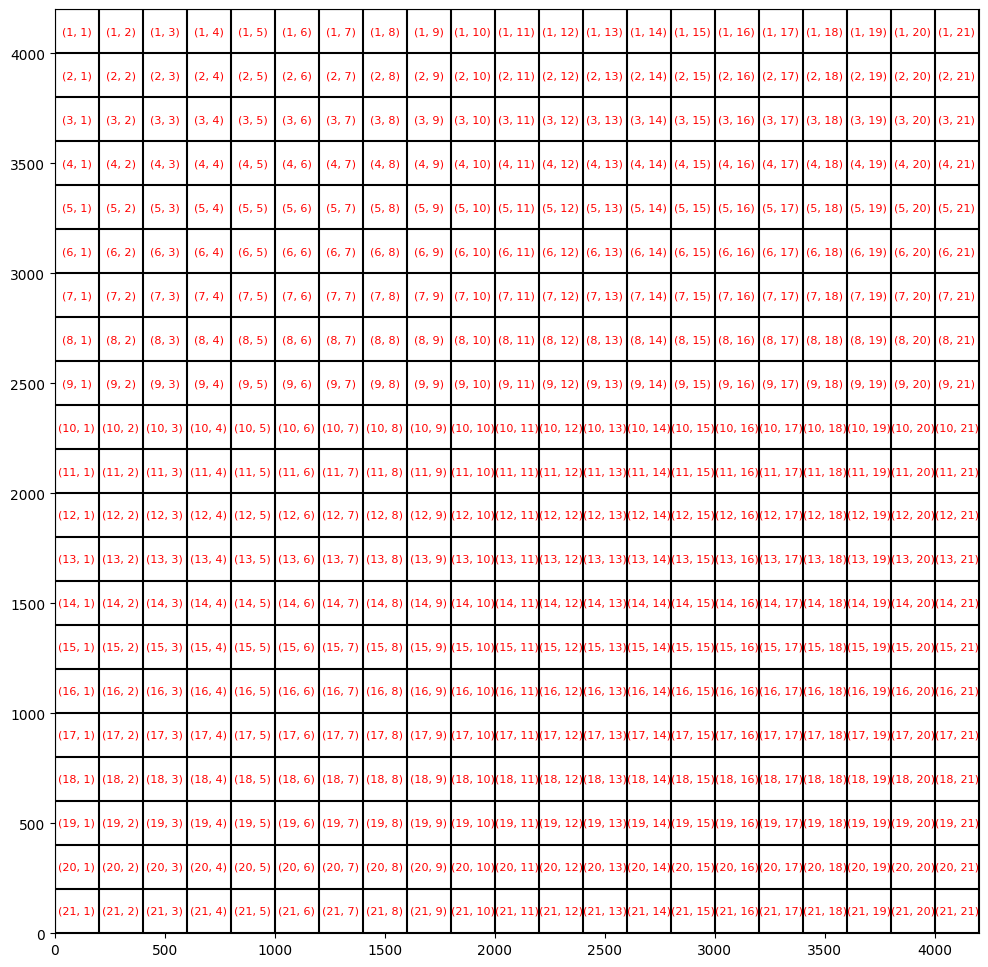

In [23]:
# Plot the model grid
fig, ax = plt.subplots(figsize=(12, 12))
mapview = flopy.plot.PlotMapView(model=model, layer=0)
mapview.plot_grid(color='black')
# Add labels for row and column numbers/grid coordinates
for i, x in enumerate(model.modelgrid.xcellcenters[0]):
    for j, y in enumerate(model.modelgrid.ycellcenters[:,0]):
        plt.text(x, y, f'{j+1,i+1}', ha='center', va='center', color='red', fontsize=8)

plotting DIS package Util2d instance: top
plotting DIS package Util3d instance: botm


[<Axes: title={'center': ' model_top'}>,
 <Axes: title={'center': 'botm layer 1'}>]

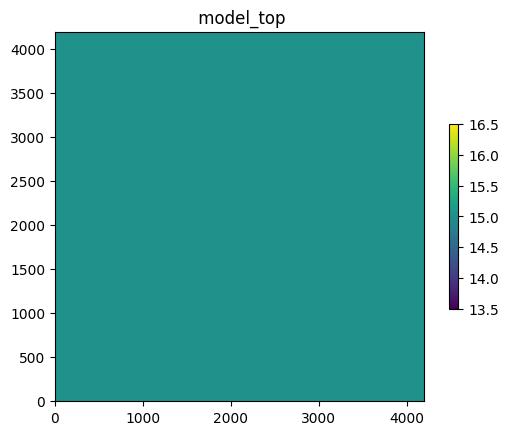

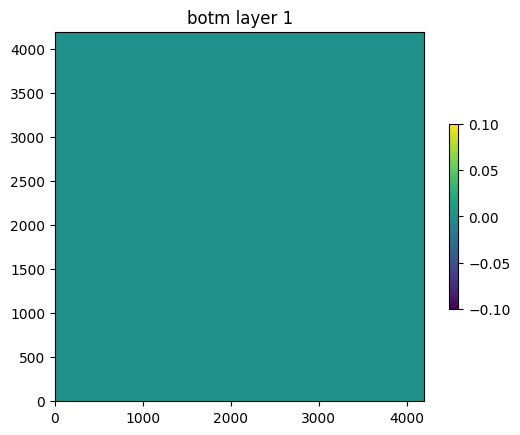

In [24]:
# Plot the model top and bottom
model.dis.plot()

In [25]:
# BAS - Basic Package

strt = 10  # Starting/initial head (m)

bas = flopy.modflow.ModflowBas(
    model, 
    strt=strt)



adding Package:  BAS6


In [26]:
# LPF - Layer-Property Flow Package

hk = 2e-4  # Horizontal hydraulic conductivity (m/s)
sy = 0.3 # Specific yield (unitless)

lpf = flopy.modflow.ModflowLpf(
    model, 
    hk=hk,
    sy=sy
    )

adding Package:  LPF


In [27]:
# WEL - Well Package
pumping_rate = -0.02  # Pumping rate (m^3/s)
well_row = int(nrow/2) # Row of the pumping well
well_col = int(ncol/2)  # Column of the pumping well
well_lay = 0  # Layer, row, column of the pumping well

print ('The well is located in cell (LRC): ', well_lay+1, well_col+1, well_row+1)

stress_period_data={0: [well_lay, well_row, well_col, pumping_rate]} # Stressperiod: [Layer, Row, Column, Pumping rate]

wel = flopy.modflow.ModflowWel(
    model, 
    stress_period_data=stress_period_data,
    ipakcb=53 # Unit number for the (.cbc) output file
    )



The well is located in cell (LRC):  1 11 11
Adding mf_theis.cbc (unit=53) to the output list.
adding Package:  WEL


In [28]:
# PCG - Preconditioned Conjugate-Gradient Package

pcg = flopy.modflow.ModflowPcg(
    model, 
    mxiter=50, # Maximum number of iterations
    hclose=1e-3, # Head change criterion for convergence (m) --> 1 mm
    relax=1.0, # Relaxation parameter
    )

adding Package:  PCG


In [29]:
# OC - Output Control Package

# Save head and budget file for each timestep in each stress period
per_dict = {(kper,nstp): ['save head', 'save budget'] for kper in range(model.dis.nper) for nstp in range(model.dis.nstp[kper])} # 'print head'

# create output control file using dictionary
oc = flopy.modflow.ModflowOc(
    model,
    stress_period_data=per_dict)


Adding mf_theis.hds (unit=51) to the output list.
adding Package:  OC


In [30]:
# Write the input files
model.write_input()



Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  WEL
   Package:  PCG
   Package:  OC
 


In [31]:
# run the model
model.run_model()

FloPy is using the following executable to run the model: ..\..\..\..\..\..\..\..\GWV8\MF2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: mf_theis.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/10/10 21:21:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step: 

(True, [])

In [32]:
# Post-processing
# Load the heads and budget files
hds_name = modelname + ".hds"
cbc_name = modelname + ".cbc"
hdobj = flopy.utils.HeadFile(os.path.join(model_ws, hds_name))
cbb = flopy.utils.CellBudgetFile(os.path.join(model_ws, cbc_name))


In [33]:
# Get the heads for a specific time step and specific location (layer, row, column)
hdobj.get_alldata()[:, well_lay, well_row, well_col] # heads at [0(layer), 6(row), 6(col)] for all times (well location)

array([9.832648 , 9.667697 , 9.506209 , 9.34917  , 9.19745  , 9.051779 ,
       8.912723 , 8.7806635, 8.6558   , 8.538148 , 8.427558 , 8.323731 ,
       8.226255 , 8.134631 , 8.048305 , 7.966701 , 7.889249 , 7.815402 ,
       7.7446566, 7.6765604, 7.610718 , 7.5467877, 7.4844847, 7.4235682,
       7.3638406, 7.305137 , 7.2473216, 7.1902804, 7.1339183, 7.0781546,
       7.02292  , 6.9681554, 6.9138093, 6.859835 , 6.8061943, 6.75285  ,
       6.6997695, 6.64692  , 6.5942693, 6.5417795, 6.4894056, 6.4370885,
       6.384745 , 6.332285 , 6.2795625, 6.226388 , 6.172517 , 6.117641 ,
       6.0613832, 6.003291 , 5.9428363, 5.8794117, 5.8123364],
      dtype=float32)

In [34]:
# Define the position where the head will be extracted
head_locations = [
    (well_lay, well_row, well_col),
    (0, 5, 15), (0, 5, 5), (0, 5, 0)] # (layer, row, column)

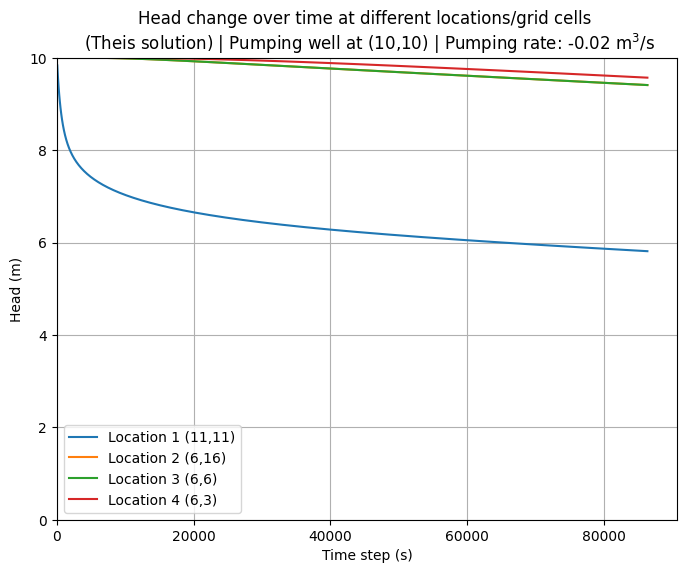

In [35]:
# Plot heads
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the heads
for i, loc in enumerate(head_locations):
    head = hdobj.get_alldata()[:, loc[0], loc[1], loc[2]]
    time = hdobj.get_times()
    ax.plot(time, head, label=f'Location {i+1} ({loc[1]+1},{loc[2]+1})')

ax.set_xlabel('Time step (s)')
ax.set_ylabel('Head (m)')
ax.set_title(f'Head change over time at different locations/grid cells \n (Theis solution) | Pumping well at ({well_row},{well_col}) | Pumping rate: {pumping_rate} m$^3$/s')

ax.grid()
ax.set_ylim(0, 10)
ax.set_xlim(0, )

plt.legend()